In [225]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.fft as fft
from scipy.interpolate import interp1d

In [248]:
# mpk = np.genfromtxt(r'C:/Users/satvi/PhD_thesis/kk.dat')
mpk = np.genfromtxt(r'C:/Users/satvi/PhD_thesis/kk.dat')

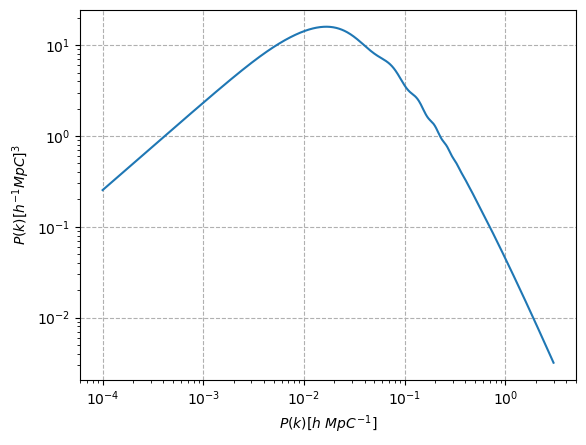

In [227]:
plt.plot(mpk[:,0],mpk[:,1])
plt.grid(linestyle = "dashed")
plt.ylabel('$P(k) [h^{-1}MpC]^3$')
plt.xlabel('$P(k) [h~MpC^{-1}]$')
plt.yscale('log')
plt.xscale('log')

In [228]:
interpolation_func = interp1d(mpk[:,0], mpk[:,1], kind='linear')

# 1D array in k space 

# 2D array in k space whose ifft is real

In [229]:
# # I HAVE MADE A MISTAKE HERE, NEED TO USE THE RAYLEIGH AS THE MAGNITUDE, NOT THE REAL PART#########
# ##############################################################################################
# def delta_k_array(length):
    
#     l_by_2 = int(length/2)
#     k_grid = k_grid_fft(length)
    
#     p_k_fft = interpolation_func(k_grid)
#     del_k_fft = np.zeros((length,length))

#     #Creating a larger 2d array with the real part of the delta_k according to numpy convention
#     for i in range(0,l_by_2+1):
#         for j in range(0,l_by_2+1):
#             if(i!=0 or j!=0):
#                 del_k_fft[i,j] = np.random.rayleigh(scale = np.sqrt(p_k_fft[i,j]))  
#                 if(i>0 and j>0):
#                     del_k_fft[length-i,length-j]=del_k_fft[i,j]
#                     del_k_fft[length-i,j] = del_k_fft[i,j]
#                     del_k_fft[i,length-j] = del_k_fft[i,j]
#                 if(i==0 and j>0 and j<l_by_2):
#                     del_k_fft[i,length-j]=del_k_fft[i,j]
#                 if(j==0 and i>0 and i<l_by_2):
#                     del_k_fft[length-i,j]=del_k_fft[i,j]
                    
#     #Doing the same conjugate convention for the imaginary part of the delta_k field to get real transformed values

#     phase = np.zeros((length,length))
#     p=np.exp(np.random.uniform(0,2*np.pi,size=((length,l_by_2+1))))
#     ph = p *(del_k_fft[:length,:l_by_2+1])
#     for i in range(0,l_by_2+1):
#         for j in range(0,l_by_2+1):
#             if(i>0 and j==0 and i<l_by_2):
#                 phase[i,j] = ph[i,j]
#                 phase[length-i,j]=-ph[i,j]

#             if(j>0 and i==0 and j<l_by_2):
#                 phase[i,j] = ph[i,j]
#                 phase[i,length-j]=-ph[i,j]

#             if(i>0 and j>0):
#                 phase[i,j] = ph[i,j]
#                 phase[length-i,length-j] = -ph[i,j]


#                 if(i<l_by_2 and j<l_by_2):
#                     phase[i+l_by_2,j] = ph[l_by_2+i,j]
#                     phase[l_by_2-i,length-j] = - phase[i+l_by_2,j]


#     phase[l_by_2,l_by_2] = 0.0
    
#     delta_k_fft = del_k_fft + phase*1j
#     k_grid[0,0]=0 #restoring original values
#     return(delta_k_fft, k_grid)


In [230]:
# np.set_printoptions(linewidth=400)
# np.set_printoptions(precision=4)
# length = 200
# delta_k ,k_grid= delta_k_array(length)

In [231]:
# test=(np.fft.ifft2(delta_k,norm='backward'))
# np.max(test.imag),np.min(test.imag)

# White noise generation 2d

In [232]:
np.set_printoptions(linewidth=400)
np.set_printoptions(precision=4)
def distance1(length,cx,cy):
    l_by_2 = int(length/2)
    
    x_val = np.linspace(0,l_by_2*np.pi,l_by_2)+2*np.pi  #creating uniform x grid
    
    x_val_fft = np.concatenate([x_val[::-1],-x_val])
    
    xx, yy = np.meshgrid(x_val_fft, x_val_fft, indexing='ij')
    xx = np.roll(xx, shift = -l_by_2+cx, axis=0)
    yy = np.roll(yy, shift = -l_by_2+cy, axis=1)
    
    kxx = 2*np.pi/xx
    kyy = 2*np.pi/yy
    
    dist = np.zeros((length,length))
    for i in range(length):
        for j in range(length):
            dist[i,j] = np.sqrt((xx[i,j])**2 + (yy[i,j])**2)
    #dist = dist + 2*np.pi # to avoid division by zero
    return x_val_fft, kxx,kyy, dist



In [233]:
def pk_whitenoise(length):
    cx = int(length/2)
    cy=cx
    white_noise = np.random.normal(loc=0,scale=1,size=length**2).reshape(length,length)
    
    x_val_fft = distance1(length,cx,cy)[0]
    kxx = distance1(length,cx,cy)[1]
    kyy = distance1(length,cx,cy)[2]
    
    k_grid = np.zeros((length,length))
    
    for i in range(length):
        for j in range(length):
            k_grid[i,j] = np.sqrt(kxx[i,j]**2 + kyy[i,j]**2)
        
    del_k = interpolation_func(k_grid)    #Power spectra values for the k grid           

    white_noise_fft = np.fft.fft2(white_noise,norm='backward')
    
    #convolute in k space

    delta_k_conv = white_noise_fft * np.sqrt(del_k)
    delta_k_conv[0,0] = 0   #setting dc component to zero
    
    return delta_k_conv, k_grid

In [234]:
length=100
iterate=10
l_by_2 = int(length/2)
pk = np.zeros(l_by_2)
store = np.zeros((iterate,l_by_2))

for t in range(iterate):
    k_val_conv = pk_whitenoise(length)[0][1:,1:]
    k_grid = pk_whitenoise(length)[1][1:,1:]
    
    kgrid_flat = (k_grid).flatten()
    deltakconvflat = k_val_conv.flatten()
    
    kspace = np.logspace(np.log10(kgrid_flat.min()),np.log10(kgrid_flat.max()),l_by_2)

    for i in range(0,l_by_2-1):
        cond = (kgrid_flat >=kspace[i]) & (kgrid_flat<kspace[i+1])
        pk[i] = (np.abs(deltakconvflat[cond])**2).sum()/len( deltakconvflat[cond] )
    
        store[t] = pk

C:\Users\satvi\AppData\Local\Temp\ipykernel_23104\4105557529.py:18: RuntimeWarning: invalid value encountered in double_scalars
  pk[i] = (np.abs(deltakconvflat[cond])**2).sum()/len( deltakconvflat[cond] )


In [235]:
pk_mean=np.mean(store/length**2,axis=0),
pk_std = np.std(store/length**2,axis=0)
pk_mean=pk_mean[0]

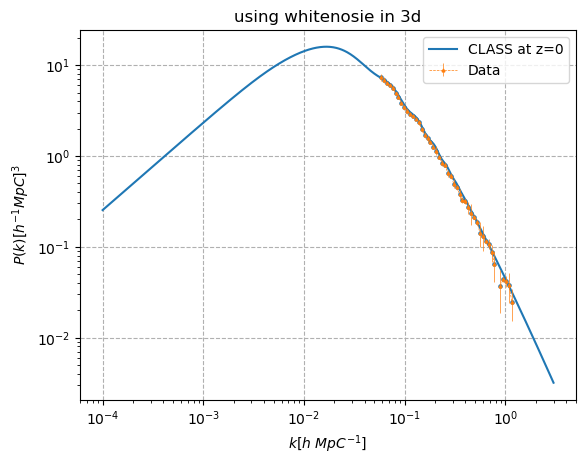

In [236]:
plt.scatter(kspace[1:],pk_mean[1:],s=5)
plt.plot(mpk[:,0],mpk[:,1],label="CLASS at z=0")
plt.grid(linestyle = "dashed")
plt.ylabel('$P(k) [h^{-1}MpC]^3$')
plt.xlabel('$k [h~MpC^{-1}]$')

plt.errorbar(kspace[1:l], pk_mean[1:], yerr=pk_std[1:], fmt='--^', label='Data', linewidth=0.5,markersize=2.0)
plt.title("using whitenosie in 3d")
plt.xscale('log')
plt.yscale('log')
plt.legend()
# plt.savefig("Pkz_0_2d_kspace")

In [237]:
delta_x_conv = np.fft.ifft2(pk_whitenoise(length)[0],norm='backward')   #converting back to real space

Text(0.5, 1.0, 'Generated by Convolving correlations with white noise')

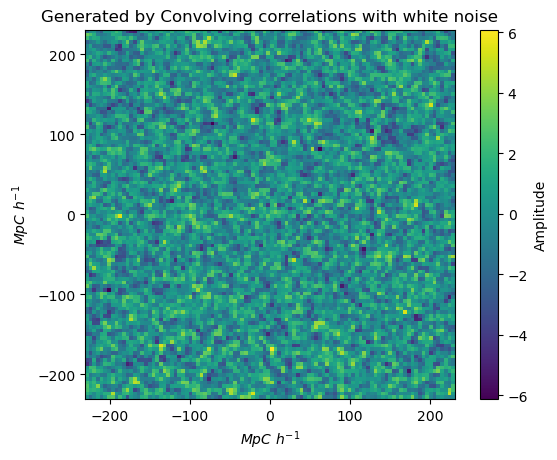

In [238]:
dist = distance1(length,l_by_2,l_by_2)[3]
distmax = np.max(dist)

plt.imshow((delta_x_conv.real), extent=[-distmax,distmax, -distmax, distmax],cmap='viridis', origin='lower')
plt.colorbar(label='Amplitude')  # Add a colorbar with label
plt.xlabel('$MpC~h^{-1}$')  # x-axis label (if you have x-axis values)
plt.ylabel('$MpC~h^{-1}$')  # y-axis label (if you have y-axis values)
#plt.title("Generated by Convolving correlations with white noise")

# White noise generation 3d

In [239]:
np.set_printoptions(linewidth=400)
np.set_printoptions(precision=4)
def distance3d(length,cx,cy,cz):
    l_by_2 = int(length/2)
    
    x_val = np.linspace(0,l_by_2*np.pi,l_by_2)+2*np.pi  #creating uniform x grid
    
    x_val_fft = np.concatenate([x_val[::-1],-x_val])
    
    xx, yy, zz = np.meshgrid(x_val_fft, x_val_fft, x_val_fft, indexing='ij')
    xx = np.roll(xx, shift = -l_by_2+cx, axis=0)
    yy = np.roll(yy, shift = -l_by_2+cy, axis=1)
    zz = np.roll(yy, shift = -l_by_2+cz, axis=2)
    
    kxx = 2*np.pi/xx
    kyy = 2*np.pi/yy
    kzz = 2*np.pi/zz
    
    dist = np.zeros((length,length,length))
    for i in range(length):
        for j in range(length):
            for k in range(length):
                dist[i,j,k] = np.sqrt((xx[i,j,k])**2 + (yy[i,j,k])**2 + zz[i,j,k]**2)
    #dist = dist + 2*np.pi # to avoid division by zero
    return x_val_fft, kxx,kyy, kzz, dist



In [240]:
def pk_whitenoise3d(length):
    cx = int(length/2)
    cy=cx
    cz=cx
    white_noise = np.random.normal(loc=0,scale=1,size=length**3).reshape(length,length,length)
    
    x_val_fft = distance1(length,cx,cy)[0]
    kxx = distance3d(length,cx,cy,cz)[1]
    kyy = distance3d(length,cx,cy,cz)[2]
    kzz = distance3d(length,cx,cy,cz)[3]
    dist= distance3d(length,cx,cy,cz)[4]
    
    k_grid = np.zeros((length,length,length))
    
    for i in range(length):
        for j in range(length):
            for k in range(length):
                k_grid[i,j,k] = np.sqrt(kxx[i,j,k]**2 + kyy[i,j,k]**2 + kzz[i,j,k]**2)
        
    del_k = interpolation_func(k_grid)    #Power spectra values for the k grid           

    white_noise_fft = np.fft.fftn(white_noise,norm='backward')
    
    #convolute in k space

    delta_k_conv = white_noise_fft * np.sqrt(del_k)
    delta_k_conv[0,0,0] = 0   #setting dc component to zero
    
    return delta_k_conv, k_grid

In [241]:
length=50
iterate=5
l_by_2 = int(length/2)
pk = np.zeros(l_by_2)
store = np.zeros((iterate,l_by_2))

for t in range(iterate):
    k_val_conv = pk_whitenoise3d(length)[0][1:,1:,1:]
    k_grid = pk_whitenoise3d(length)[1][1:,1:,1:]
    
    kgrid_flat = (k_grid).flatten()
    deltakconvflat = k_val_conv.flatten()
    
    kspace = np.logspace(np.log10(kgrid_flat.min()),np.log10(kgrid_flat.max()),l_by_2)

    for i in range(0,l_by_2-1):
        cond = (kgrid_flat >=kspace[i]) & (kgrid_flat<kspace[i+1])
        pk[i] = (np.abs(deltakconvflat[cond])**2).sum()/len( deltakconvflat[cond] )
    
        store[t] = pk

In [242]:
pk_mean=np.mean(store/length**3,axis=0),
pk_std = np.std(store/length**3,axis=0)
pk_mean=pk_mean[0]

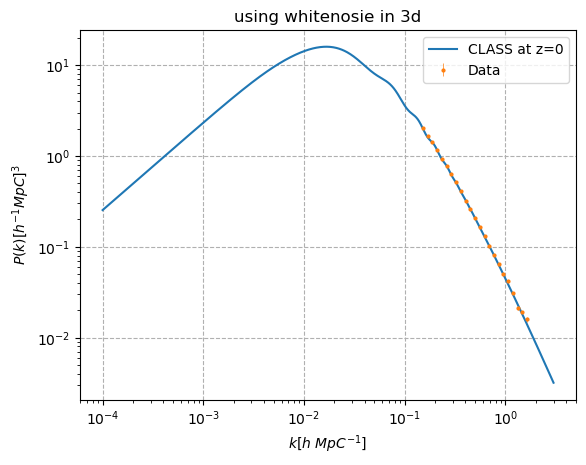

In [244]:
k_space = np.zeros(len(kspace)-1)

for i in range(len(kspace)-2):
    k_space[i] = (kspace[i+1]+kspace[i+2])/2
k_space[-1] = kspace[-1]


plt.plot(mpk[:,0],mpk[:,1],label="CLASS at z=0")
plt.grid(linestyle = "dashed")
plt.ylabel('$P(k) [h^{-1}MpC]^3$')
plt.xlabel('$k [h~MpC^{-1}]$')

plt.errorbar(k_space, pk_mean[1:], yerr=pk_std[1:], fmt='o', label='Data', linewidth=0.5,markersize=2.0)
plt.title("using whitenosie in 3d")
plt.xscale('log')
plt.yscale('log')
plt.legend()
# plt.savefig("Pkz_0_2d_kspace")

In [245]:
convk3d = pk_whitenoise3d(length)[0]
xconv3d = np.fft.ifftn(convk3d,norm='backward')   #converting back to real space

Text(0.5, 0, '$\\delta$')

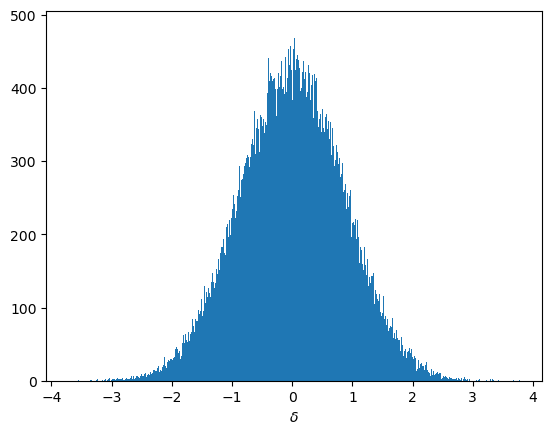

In [246]:
plt.hist(xconv3d.real.flatten(),bins=1000)
plt.xlabel('$\delta$')
# plt.savefig("matterdensity_pdf_50")